In [1]:
import os
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from joblib import Parallel, delayed
from tqdm.auto import tqdm


load_dotenv()

# check if MPL_STYLE is set in the environment, else use default
if "MPL_STYLE" not in os.environ:
    os.environ["MPL_STYLE"] = "seaborn-v0_8-notebook"
plt.style.use(os.environ["MPL_STYLE"])

In [2]:
metric_dict = {
    "total_mass": (r"M_\mathrm{tot.}", None, r"M_\odot", ((5, 2e4), "log", None)),
    "within_r_tidal_total_mass": (
        r"M_\mathrm{tot.,\;d\leqslant r_\mathrm{tidal}}",
        None,
        r"M_\odot",
        ((5, 2e4), "log", None),
    ),
    "within_2x_r_tidal_total_mass": (
        r"M_\mathrm{tot.,\;d\leqslant 2r_\mathrm{tidal}}",
        None,
        r"M_\odot",
        ((5, 2e4), "log", None),
    ),
    "n_star": (
        r"N",
        None,
        None,
        ((2, 2e4), "log", None),
    ),
    "n_binary_star": (
        r"N_\mathrm{bin.}",
        None,
        None,
        ((2, 2e4), "log", None),
    ),
    "n_hard_binary_system": (
        r"N_\mathrm{hard\;bin.\;sys.}",
        None,
        None,
        ((2, 2e4), "log", None),
    ),
    "n_unresolved_binary_system": (
        r"N_\mathrm{unres.\;bin.\;sys.}",
        None,
        None,
        ((2, 2e4), "log", None),
    ),
    "n_wide_binary_system": (
        r"N_\mathrm{wide\;bin.\;sys.}",
        None,
        None,
        ((0.9, 90), "log", None),
    ),
    "bin_frac": (
        r"f_\mathrm{bin.\;sys.}",
        r"\dfrac{N_\mathrm{bin.\;sys.}}{N_\mathrm{single} + N_\mathrm{bin.\;sys.}}",
        None,
        ((0, 0.9), "linear", ((0.2, 0), (0.1, 0))),
    ),
    "hard_bin_frac": (
        r"f_\mathrm{hard\;bin.\;sys.}",
        r"\dfrac{N_\mathrm{hard\;bin.\;sys.}}{N_\mathrm{single} + N_\mathrm{bin.\;sys.}}",
        None,
        ((0, 0.9), "linear", ((0.2, 0), (0.1, 0))),
    ),
    "unresolved_bin_frac": (
        r"f_\mathrm{unres.\;bin.\;sys.}",
        r"\dfrac{N_\mathrm{unres.\;bin.\;sys.}}{N_\mathrm{single} + N_\mathrm{bin.\;sys.}}",
        None,
        ((0, 0.9), "linear", ((0.2, 0), (0.1, 0))),
    ),
    "r_half_mass": (
        r"r_\mathrm{hm}",
        None,
        r"\mathrm{pc}",
        ((0, 7), "linear", ((2, 0), (1, 0))),
    ),
    "r_tidal": (
        r"r_\mathrm{tidal}",
        None,
        r"\mathrm{pc}",
        ((0, 40), "linear", ((8, 4), (4, 0))),
    ),
    "f_r": (
        r"f_r",
        r"\dfrac{r_\mathrm{hm}}{r_\mathrm{tidal}}",
        None,
        ((0, 1.6), "linear", ((0.5, 0), (0.1, 0))),
    ),
}

cat_keys = [
    "init_gc_radius",
    "init_metallicity",
    "init_mass_lv",
    "init_pos",
]

In [3]:
OUTPUT_BASE = Path(os.getenv("OUTPUT_BASE"))
overall_stats_root_path = (OUTPUT_BASE / "overall_stats").resolve()
overall_stats_parquet_path = (
    OUTPUT_BASE / "cache" / "stats" / "overall_stats.parquet"
).resolve()

# load overall stats dataframe directly from parquet if exists
if overall_stats_parquet_path.is_file():
    overall_stats_df = pd.read_parquet(overall_stats_parquet_path)
else:
    # check if the path exists
    if not overall_stats_root_path.is_dir():
        raise NotADirectoryError(overall_stats_root_path)
    # merge all csv files in the overall_stats_root_path
    overall_stats_df = (
        pd.concat(
            [
                pd.read_csv(overall_stats_root_path / f)
                for f in tqdm(
                    os.listdir(overall_stats_root_path),
                    desc="Loading Overall Stats CSVs",
                    dynamic_ncols=True,
                    unit="file",
                    leave=False,
                )
                if f.endswith(".csv")
            ],
            ignore_index=True,
        )
        .sort_values(
            by=["init_gc_radius", "init_metallicity", "init_mass_lv", "init_pos"]
        )
        .reset_index(drop=True)
    )
    # save to parquet for faster loading next time
    overall_stats_parquet_path.parent.mkdir(parents=True, exist_ok=True)
    overall_stats_df.to_parquet(overall_stats_parquet_path)

In [4]:
aligned_parquet_path = OUTPUT_BASE / "cache" / "stats" / "aligned_overall_stats.parquet"

if aligned_parquet_path.is_file():
    aligned_df = pd.read_parquet(aligned_parquet_path)
else:
    bin_frac_denom = (
        # N_single + N_binary_system
        (overall_stats_df["n_star"] - overall_stats_df["n_binary_star"])
        + overall_stats_df["n_binary_system"]
    ).replace(0, np.nan)

    # calculate the new metrics
    overall_stats_df["f_r"] = (
        overall_stats_df["r_half_mass"] / overall_stats_df["r_tidal"]
    )
    overall_stats_df["n_single_star"] = (
        overall_stats_df["n_star"] - overall_stats_df["n_binary_star"]
    )
    # calculate different binary fractions
    overall_stats_df["bin_frac"] = overall_stats_df["n_binary_system"] / bin_frac_denom
    overall_stats_df["hard_bin_frac"] = (
        overall_stats_df["n_hard_binary_system"] / bin_frac_denom
    )
    overall_stats_df["unresolved_bin_frac"] = (
        overall_stats_df["n_unresolved_binary_system"] / bin_frac_denom
    )

    uni_timestamp_grid = np.arange(0, overall_stats_df["timestamp"].max() + 1, 1)

    grouped_keys = ["galactic_x"] + cat_keys

    def process_group(group_data):
        grouped_attr_values, group_df = group_data
        return (
            group_df.groupby("timestamp", observed=True)[list(metric_dict.keys())]
            .mean()
            .reindex(np.union1d(group_df["timestamp"].to_numpy(), uni_timestamp_grid))
            .sort_index()
            .interpolate("index", limit_area="inside")
            .reindex(uni_timestamp_grid)
            .assign(
                **dict(
                    zip(
                        grouped_keys,
                        grouped_attr_values,
                    )
                ),
                timestamp=lambda df: df.index.values,
            )
        )

    groups = list(
        overall_stats_df.groupby(
            grouped_keys,
            observed=True,
            sort=False,
            group_keys=False,
        )
    )
    print(f"Using {(n_cpu := os.cpu_count() or 1)} CPU cores for parallel processing")
    aligned_df = pd.concat(
        Parallel(n_jobs=n_cpu, backend="loky")(
            delayed(process_group)(group)
            for group in tqdm(
                groups,
                desc="submit processing tasks",
                leave=False,
            )
        ),
        ignore_index=True,
    ).dropna(subset=list(metric_dict.keys()), how="all")

    aligned_df.to_parquet(aligned_parquet_path)

del overall_stats_df

In [5]:
# check how many combinations of cat_keys
print(aligned_df[cat_keys].drop_duplicates().shape[0], "combinations of", cat_keys)

3286 combinations of ['init_gc_radius', 'init_metallicity', 'init_mass_lv', 'init_pos']


In [6]:
agg_df = (
    aligned_df.groupby(
        [
            "galactic_x",
            "init_gc_radius",
            "init_metallicity",
            "init_mass_lv",
            "timestamp",
        ],
        observed=True,
        sort=False,
    )[list(metric_dict.keys())]
    .agg(["mean", "std", "count"])
    .reset_index()
    .rename(
        columns=lambda x: (
            "_".join([str(c) for c in x if c]).rstrip("_")
            if isinstance(x, tuple)
            else x
        )
    )
)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

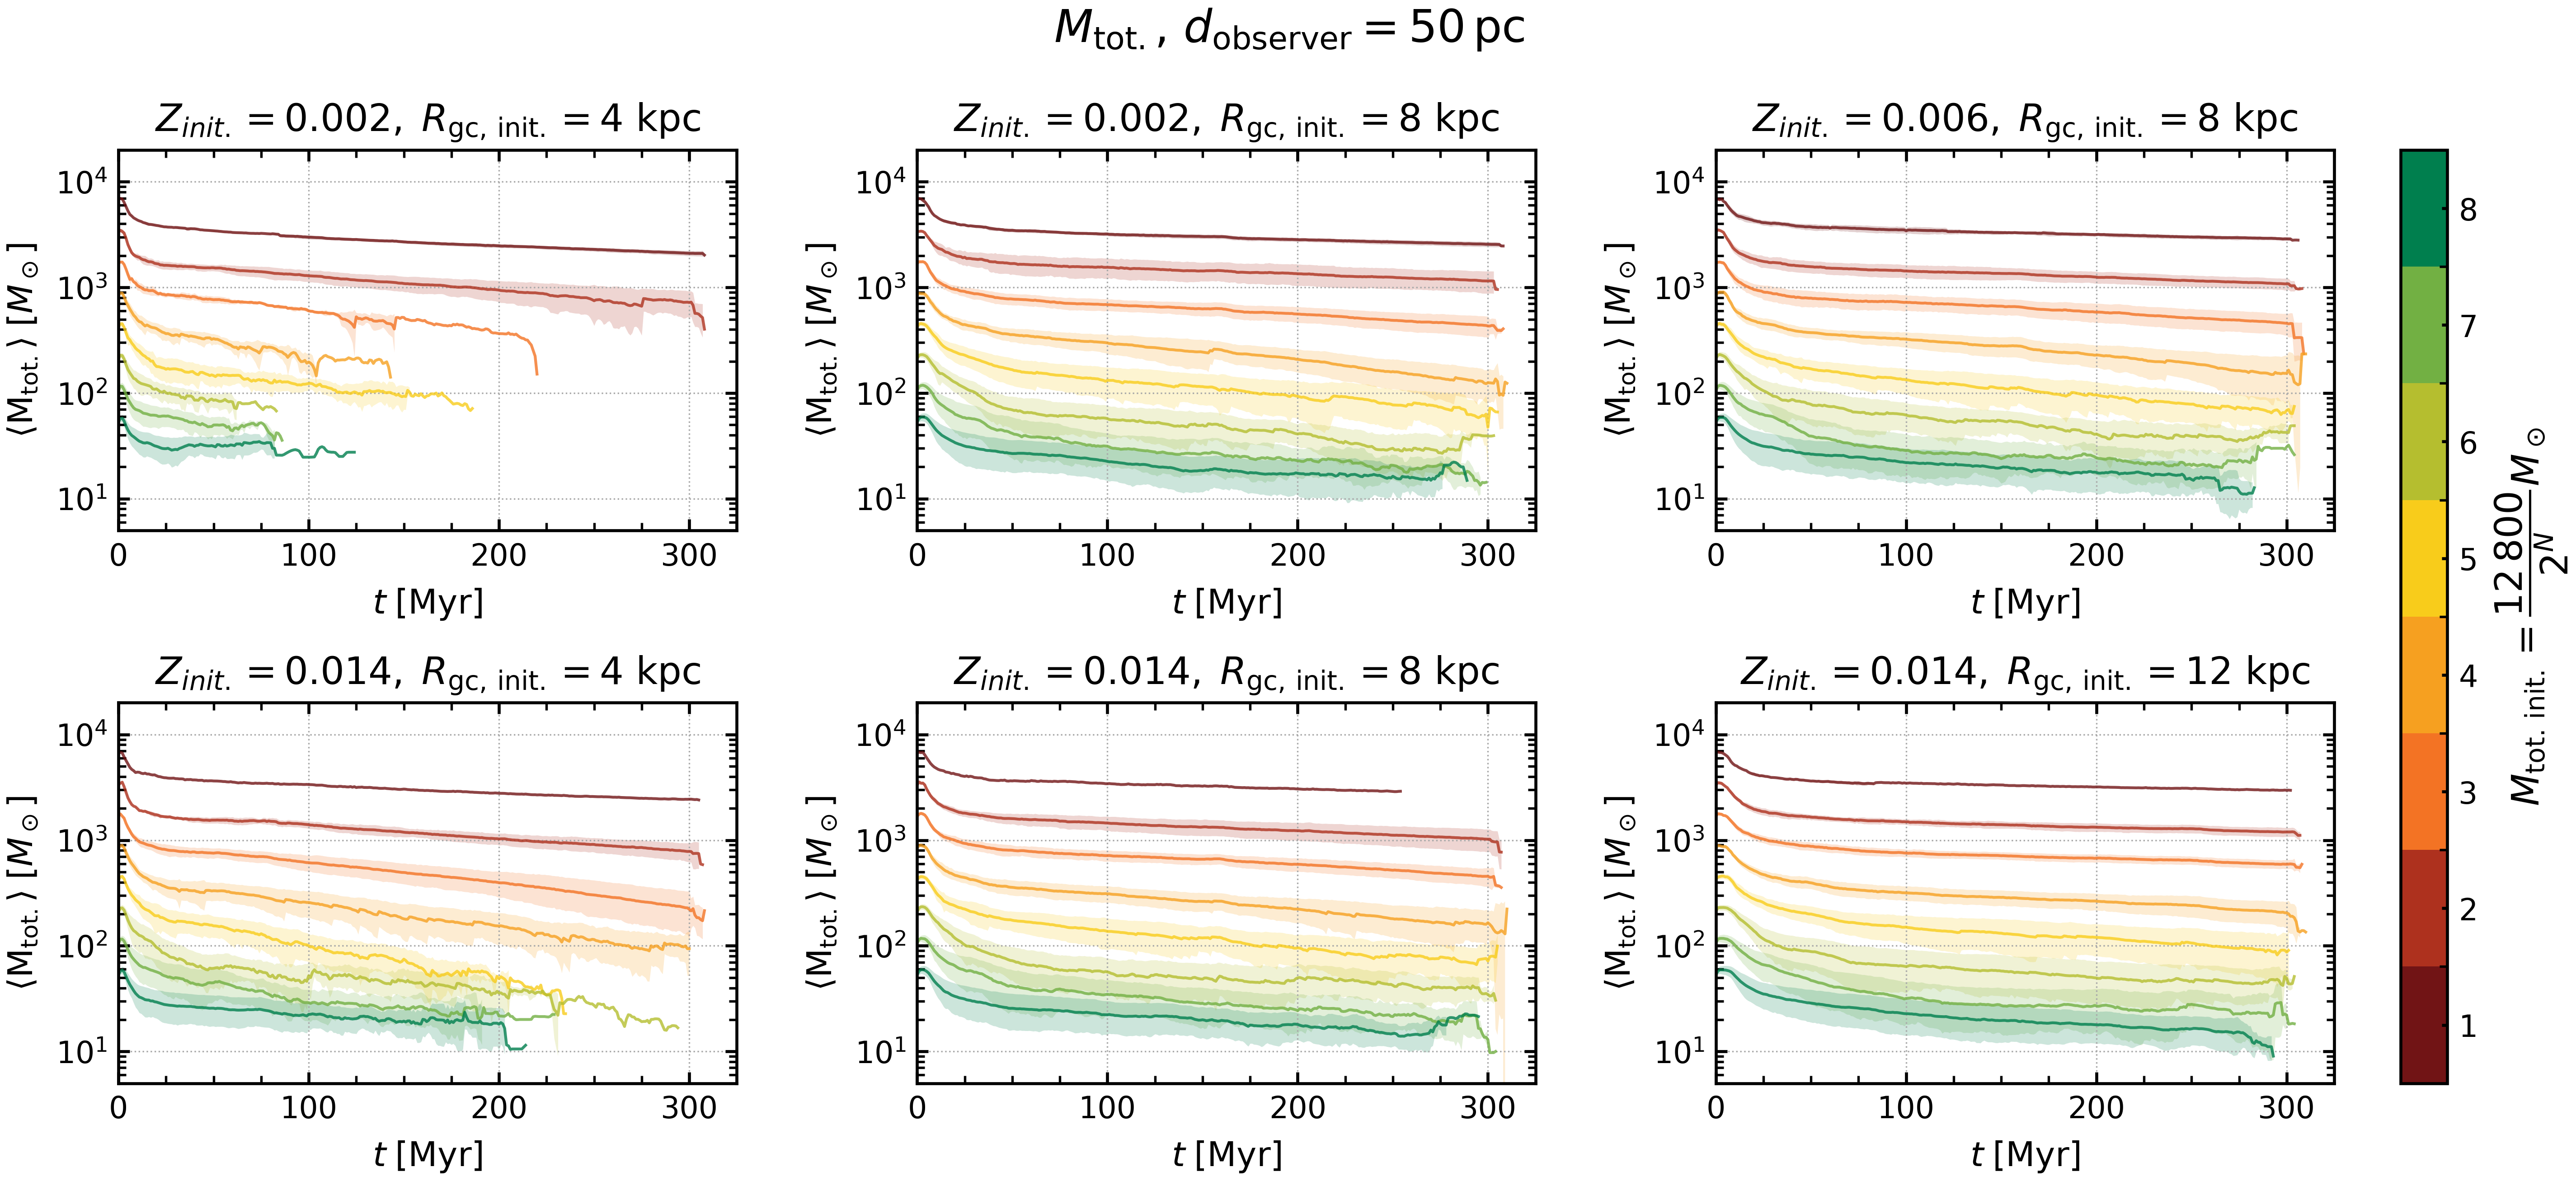

In [ ]:
for metric_to_plot in (
    metric_pbar := tqdm(
        metric_dict.keys(), total=len(metric_dict), leave=False, dynamic_ncols=True
    )
):
    metric_pbar.set_description(f"Plotting {metric_to_plot}")

    fig_export_path = OUTPUT_BASE / "figures" / "overall" / f"{metric_to_plot}"
    # fig_export_path = OUTPUT_BASE / "figures" / "overall"
    fig_export_path.mkdir(parents=True, exist_ok=True)

    mass_levels = list(range(1, 9))
    cmap = mpl.colors.ListedColormap(
        [
            "#711415",
            "#ae311e",
            "#f37324",
            "#f6a020",
            "#f8cc1b",
            "#b5be2f",
            "#72b043",
            "#007f4e",
        ]
    )
    norm = mpl.colors.BoundaryNorm(
        boundaries=np.arange(0.5, 8.5 + 1, 1), ncolors=cmap.N
    )

    attr_pairs = [(2, 4), (2, 8), (6, 8), (14, 4), (14, 8), (14, 12)]

    for fig_idx, (dist_pc, group_df) in (
        dist_pbar := tqdm(
            enumerate(agg_df.groupby("galactic_x", observed=True, sort=False)),
            total=agg_df["galactic_x"].nunique(),
            leave=False,
            dynamic_ncols=True,
        )
    ):
        dist_pbar.set_description(f"Plotting distance={dist_pc} pc")

        fig, axs = plt.subplots(
            nrows=2,
            ncols=3,
            figsize=(19, 8),
            dpi=300,
            constrained_layout=True,
            gridspec_kw=dict(hspace=0.06, wspace=0.08),
        )

        # unpack the metric info
        (
            metric_label_tex,
            metric_formula_tex,
            metric_unit_tex,
            (y_plot_range, y_scale, y_locator),
        ) = metric_dict[metric_to_plot]

        metric_title = (
            metric_label_tex
            if metric_formula_tex is None
            else f"{metric_label_tex}={metric_formula_tex}"
        )
        y_label_tex = (
            rf"$\langle \mathrm{{{metric_label_tex}}} \rangle$"
            if metric_unit_tex is None
            else rf"$\langle \mathrm{{{metric_label_tex}}} \rangle\;[{metric_unit_tex}]$"
        )

        if y_scale == "log":
            y_major_locator = mpl.ticker.LogLocator(base=10.0, numticks=10)
            y_minor_locator = mpl.ticker.LogLocator(
                base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10
            )
        else:
            (
                (y_major_loc_base, y_major_loc_offset),
                (y_minor_loc_base, y_minor_loc_offset),
            ) = y_locator

            y_major_locator = mpl.ticker.MultipleLocator(
                y_major_loc_base, offset=y_major_loc_offset
            )
            y_minor_locator = mpl.ticker.MultipleLocator(
                y_minor_loc_base, offset=y_minor_loc_offset
            )

        fig.suptitle(
            rf"${metric_title}$, " rf"$d_\mathrm{{observer}}={dist_pc}\,\mathrm{{pc}}$",
            fontsize=24,
            y=1.04,
            va="bottom",
        )

        for (init_metallicity, init_gc_radius), ax in zip(attr_pairs, axs.flat):
            subgroup = group_df[
                (group_df["init_metallicity"] == init_metallicity)
                & (group_df["init_gc_radius"] == init_gc_radius)
            ]

            for mass_lv in mass_levels:
                mass_df = subgroup[subgroup["init_mass_lv"] == mass_lv]
                if mass_df.empty:
                    continue

                ax.plot(
                    mass_df["timestamp"],
                    mass_df[(metric_to_plot, "mean")],
                    color=cmap(norm(mass_lv)),
                    alpha=0.8,
                )
                ax.fill_between(
                    mass_df["timestamp"],
                    mass_df[(metric_to_plot, "mean")]
                    - mass_df[(metric_to_plot, "std")],
                    mass_df[(metric_to_plot, "mean")]
                    + mass_df[(metric_to_plot, "std")],
                    color=cmap(norm(mass_lv)),
                    alpha=0.2,
                    lw=0,
                )

            ax.set_xlim(0, 325)
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(25))
            ax.set_xlabel(r"$t\;[\mathrm{Myr}]$")

            ax.set_yscale(y_scale)
            ax.set_ylim(*y_plot_range)
            ax.yaxis.set_major_locator(y_major_locator)
            ax.yaxis.set_minor_locator(y_minor_locator)
            ax.set_ylabel(y_label_tex)

            ax.set_title(
                rf"$Z_{{init.}}={init_metallicity * 10e-4},\;"
                rf"R_\mathrm{{gc,\,init.}}={init_gc_radius}\ \mathrm{{kpc}}$",
                fontsize=20,
                y=1.02,
            )
            ax.grid(ls=":", lw=0.8, c="darkgrey")

        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        cbar = fig.colorbar(
            sm,
            ax=axs,
            orientation="vertical",
            fraction=0.08,
            pad=0.03,
            ticks=mass_levels,
        )
        cbar.set_label(
            r"$M_\mathrm{tot.\,init.}=\dfrac{12\,800}{2^N}M_\odot$", fontsize=20
        )
        cbar.ax.tick_params(direction="in", length=3)

        if fig_idx != 0:
            plt.close(fig)
        else:
            plt.show()
        fig.savefig(
            fig_export_path / f"{metric_to_plot}-{dist_pc}pc.png",
            bbox_inches="tight",
            dpi=300,
        )
    #     break
    # break